In [1]:
from __future__ import division
import tqdm
import os
import sys
sys.path.append('/mnt/disk0/home/jianwei_leejw/scripts/TESPulseFitCode')
# sys.path.append('/workspace/projects/TES/scripts')
import numpy as np
import matplotlib
# matplotlib.use('nbAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from lmfit import Model, Parameters
import pymc
# import seaborn
from scipy.stats import norm
from scipy.signal import savgol_filter
from scipy.fftpack import fft, rfft, fftshift
import pickle
import time as datetime
import pandas
import pprint

import heralded_pulses_analysis as hpa
import pulse_averaging_cw as pacw
import pulse_fit_v05 as pf
import pulse_fit_v06 as pf6
import single_photon_model_no_shift as noshift
import pulse_averaging as pa
import thres_poiss
import pulse_discrimination as pd
import thres
import stats_proc as sp

import pulse_utils as pu
import discriminator as disc
import discriminator_edges as disc_edges
import trace_param as trcp
import pulse_fit_powell as pfp

In [2]:
results_directory = './'

## Import Trace Parameters
* Height threshold
* RMS noise

In [3]:
[height_th, offset] = np.loadtxt(results_directory + 'disc_settings.dat')
offset = int(offset)
print height_th, offset

0.00794093643656 650


In [4]:
sigma0 = np.loadtxt(results_directory + 'rms.dat')
print sigma0

0.00180058629476


# Part 1: Discriminator Demo

In [5]:
# Import interesting traces to demonstrate
fl = np.genfromtxt('/mnt/disk1/analysis/20170523_TES5_75mK_95uA_trise_115ns_results/interesting_traces_220_to_240ns.txt', delimiter='\n',dtype='string')

In [6]:
# fname = fl[8]
fname = '/mnt/disk1/data/20170523_TES5_75mK_95uA_trise_115ns/doubles/C2doubles00285.trc'
time = pu.time_vector(fname)
signal = trcp.trace_extr(fname,height_th)

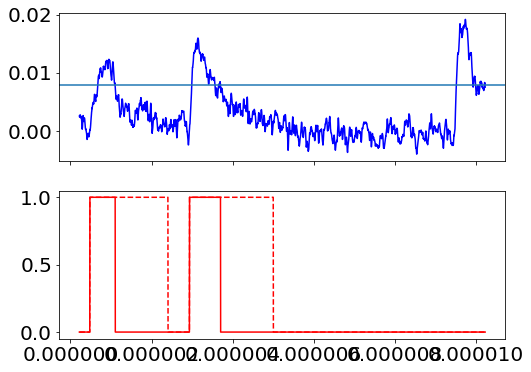

In [7]:
mask_ext = pu.disc_peak_full(signal,height_th,0,offset)

mask = pu.disc_peak_full(signal,height_th,0,0)
mask_forward = disc.disc_peak(signal,height_th,0)

f, (ax1,ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,6))
plt.tight_layout
ax1.plot(time,signal,color='blue')
ax1.axhline(height_th)
# ax2.plot(time,mask_forward,color='black')
ax2.plot(time,mask,color='red',alpha=1)
ax2.plot(time,mask_ext,color='red',alpha=1,linestyle='--')

## Saves discriminator demo trace

In [207]:
np.savetxt(results_directory+'demo_trace.dat', zip(time,signal))
np.savetxt(results_directory+'mask_forward.dat', mask_forward)
np.savetxt(results_directory+'mask.dat', mask)
np.savetxt(results_directory+'mask_ext.dat', mask_ext)

## Calculate fit parameters for amplitudes
* Import area distribution, thresholds
* Compute range of amplitudes to consider for fitting

In [8]:
pkl_file = open(results_directory+'area_distribution_lmfit_result.dat', 'rb')
area_fit_result = pickle.load(pkl_file)

In [9]:
area_mus = (area_fit_result.best_values['g1_center'], area_fit_result.best_values['g2_center'])

In [10]:
area_sigmas = (area_fit_result.best_values['g1_sigma'], area_fit_result.best_values['g2_sigma'])

In [11]:
# A. use 2 sigmas away from gaussian centers to create thresholds between number distributions
# th_areas = [(area_mus[i]-2*area_sigmas[i],area_mus[i]+2*area_sigmas[i]) 
#             for i,_ in enumerate(area_mus)]
# sum_a = th_areas[1][0]/area_mus[0]
# sum_b = th_areas[1][1]/area_mus[0]
# TwoPhoton_ThresWidth = (th_areas[1][1]-th_areas[1][0])

In [12]:
# B. use minimal overlap between distributions to create thresholds between number distributions
th_areas = np.loadtxt(results_directory+'th_areas_from_min_overlap.dat')
[th01, th12, th23] = th_areas[:3]
sum_a = th12/area_mus[0]
sum_b = th23/area_mus[0]
TwoPhoton_ThresWidth = (th23-th12)

In [13]:
# C. manual input for thresholds
# sum_a = 7.95798869853/area_mus[0]
# sum_b = 14/area_mus[0]
# TwoPhoton_ThresWidth = (14-8.3)

In [14]:
# define amplitude sum distribution as n=2 area distribution normalised to n=1 mean area
sum_mu = area_mus[1]/area_mus[0]
sum_tau = 1.0/((area_sigmas[1]/area_mus[0])**2)
print sum_a, sum_mu, sum_b

1.41215308572 1.96201152484 2.38027425857


In [15]:
# define amplitude difference distribution as n=2 area distribution normalised to n=1 mean area, shifted to zero
diff_tau = 1.0/((area_sigmas[1]/area_mus[0])**2)
diff_a = -TwoPhoton_ThresWidth/2/area_mus[0]
diff_b = TwoPhoton_ThresWidth/2/area_mus[0]
print diff_a, diff_b

-0.484060586429 0.484060586429


In [16]:
np.savetxt(results_directory+'sum_and_diff_fit_params.dat',
          np.array([sum_a,sum_mu,sum_b,sum_tau,diff_a, diff_b,diff_tau]).reshape(1,7),
           delimiter="\t",
          header = "\t".join(['sum_a', 'sum_mu', 'sum_b','sum_tau','diff_a', 'diff_b','diff_tau'])
          )

# Part 2: Lmfit Demo

In [17]:
# Loads Pulse Parameters
pulse_params =np.genfromtxt(results_directory + 'sum_and_diff_fit_params.dat',
                            delimiter="\t",
                            )
print pulse_params

[  1.41215309   1.96201152   2.38027426  18.9113961   -0.48406059
   0.48406059  18.9113961 ]


## Create 2-photon Model

In [18]:
ph1_model = np.genfromtxt(results_directory + 'ph1_model_from_cw_disc.dat',delimiter='\t',names=True)
time_f = ph1_model['time']
signal_f = ph1_model['signal']
sigma_f = ph1_model['sigma']
def one_pulse(x, x_offset=0, amplitude=1, time_f=time_f, signal_f=signal_f):
    """convert the sample single photon pulse into a function
    that can be used in a fit
    """
    x = x - x_offset
    return amplitude * np.interp(x, time_f, signal_f)
two_pulse_fit = Model(one_pulse, prefix='one_') + \
        Model(one_pulse, prefix='two_')

In [19]:
# save model
fp = open(results_directory + 'two_pulse_fit_model.dat','wb')
pickle.dump(two_pulse_fit,fp)
fp.close()

## Perform Fit

In [20]:
# Lmfit
reload(pfp)
r = pfp.fit_two_cw(time,signal,
              two_pulse_fit,
              pulse_params,
              height_th,
              sigma0)
print r.fit_report()

[[Model]]
    (Model(one_pulse, prefix='one_') + Model(one_pulse, prefix='two_'))
[[Variables]]
    one_x_offset:      6.0903e-07 (init= 7.122494e-07)
    two_x_offset:      2.9840e-06 (init= 3.035249e-06)
    sum_amplitudes:    1.79756570 (init= 1.981632)
    diff_amplitudes:  -0.19074816 (init= 0)
    one_amplitude:     0.80340876  == '(sum_amplitudes + diff_amplitudes)/2'
    two_amplitude:     0.99415693  == '(sum_amplitudes - diff_amplitudes)/2'



2.37496866859e-06
4.1080646149


/usr/local/lib/python2.7/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


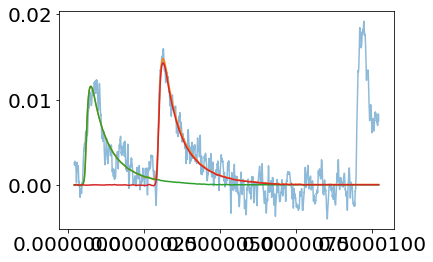

In [21]:
# Plot fit and component
# r.plot_fit()
# print r.components
plt.plot(time,signal,alpha=0.5)
plt.plot(time,r.best_fit)
comps = r.eval_components(x=time)
plt.plot(time, comps['one_'])
plt.plot(time, comps['two_'])
print r.best_values['two_x_offset']-r.best_values['one_x_offset']
plt.legend()
# plt.xlim(2e-6,4e-6)
print float(r.redchi)

In [214]:
np.savetxt('lmfit_component_one.dat',comps['one_'])
np.savetxt('lmfit_component_two.dat',comps['two_'])
with open("lmfit_component_readme.txt", "w") as text_file:
    text_file.write("{}".format(r.fit_report()))